The dataset is listed above: A *spreadsheet signnames.csv* and then *pickle files containing the train, test and validate* datasets.

Importing the Relevant Libraries

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras.utils.np_utils import to_categorical
from keras.layers import Dropout, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
import pickle
import pandas as pd
import random
import cv2

In [0]:
np.random.seed(0)

*Unpickle* the Data to make it usable.

In [0]:
with open('german-traffic-signs/train.p', 'rb') as f:
  train_data = pickle.load(f)
with open('german-traffic-signs/valid.p', 'rb') as f:
  val_data = pickle.load(f)
with open('german-traffic-signs/test.p', 'rb') as f:
  test_data = pickle.load(f)
  
  
  
X_train , y_train = train_data['features'], train_data['labels']
X_val , y_val = val_data['features'], val_data['labels']
X_test , y_test = test_data['features'], test_data['labels']

We analyze the dataset to see how it looks like.

In [139]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(34799, 32, 32, 3)
(4410, 32, 32, 3)
(12630, 32, 32, 3)


*shape* gives us the number of *images*, *dimensions in pixels* and* depth*.
The Images have a depth of 3 because they're in **RGB** format and thus the depth 3 for each color channel.

Next We Assert The dataset to see if its correct

In [0]:
assert(X_train.shape[0] == y_train.shape[0]), "No. of Images is not equals to number of labels"
assert(X_val.shape[0] == y_val.shape[0]), "No. of Images is not equals to number of labels"
assert(X_test.shape[0] == y_test.shape[0]), "No. of Images is not equals to number of labels"

assert(X_train.shape[1:] == (32,32,3)), "The Dimesnsions of the images are not 32 x 32 x 3"
assert(X_val.shape[1:] == (32,32,3)), "The Dimesnsions of the images are not 32 x 32 x 3"
assert(X_test.shape[1:] == (32,32,3)), "The Dimesnsions of the images are not 32 x 32 x 3"

Showing the training set.
If the code seems cryptic you can check out the [pandas iterrows](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.iterrows.html) documentation to see how it's used to allow you to iterate over DataFrame rows as (index, Series) pairs.  

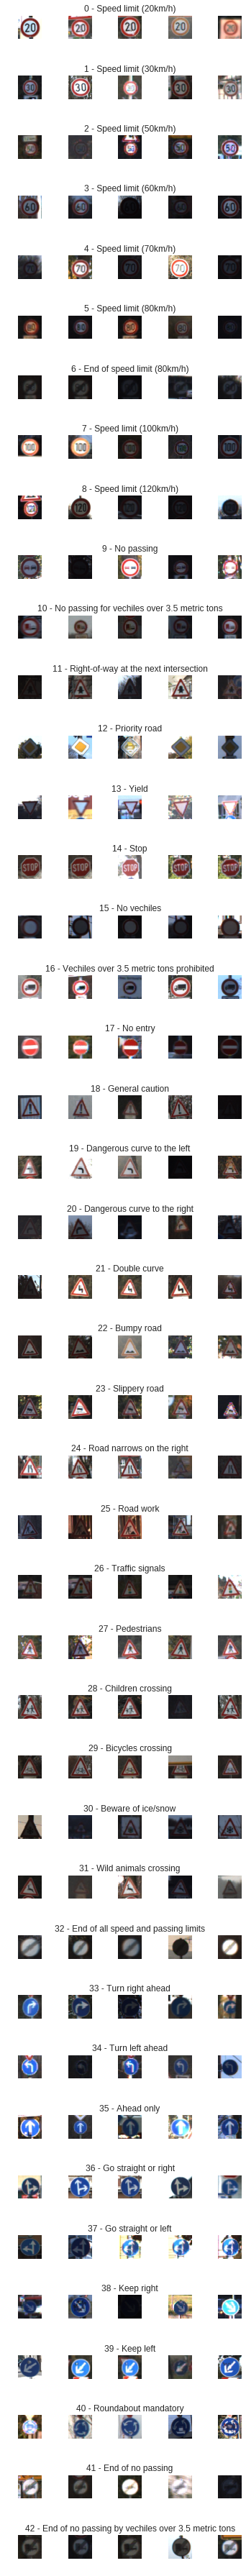

In [141]:
data = pd.read_csv('german-traffic-signs/signnames.csv')
#print(data)

num_of_samples=[]

cols = 5
num_classes = 43

fig, axs = plt.subplots(nrows=num_classes, ncols=cols, figsize=(5,50))
fig.tight_layout()

for i in range(cols):
    for j, row in data.iterrows():
        x_selected = X_train[y_train == j]
        axs[j][i].imshow(x_selected[random.randint(0,(len(x_selected) - 1)), :, :], cmap=plt.get_cmap('gray'))
        axs[j][i].axis("off")
        if i == 2:
          axs[j][i].set_title(str(j) + " - " + row["SignName"])
          num_of_samples.append(len(x_selected))

plotting the distribution of the dataset.

[180, 1980, 2010, 1260, 1770, 1650, 360, 1290, 1260, 1320, 1800, 1170, 1890, 1920, 690, 540, 360, 990, 1080, 180, 300, 270, 330, 450, 240, 1350, 540, 210, 480, 240, 390, 690, 210, 599, 360, 1080, 330, 180, 1860, 270, 300, 210, 210]


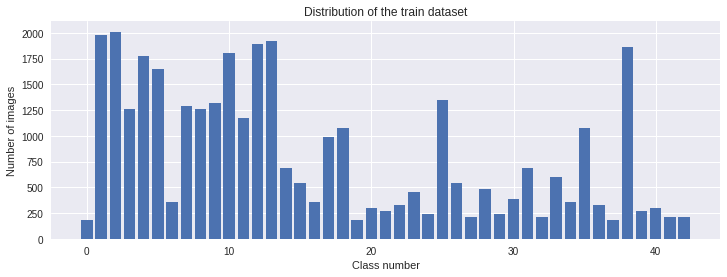

In [142]:
print(num_of_samples)
plt.figure(figsize=(12, 4))
plt.bar(range(0, num_classes), num_of_samples)
plt.title("Distribution of the train dataset")
plt.xlabel("Class number")
plt.ylabel("Number of images")
plt.show()

(32, 32, 3)
1


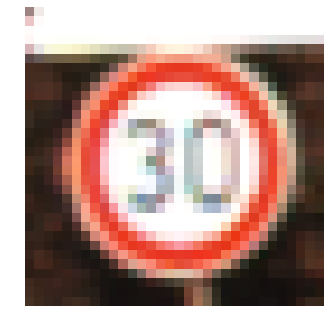

In [143]:
plt.imshow(X_train[3000])
plt.axis("off")
print(X_train[3000].shape)
print(y_train[3000])

Now We'll Convert the image to grayscale i.e binary images with only two colors black or white.
**Why Convert to grayscale?** , Well for traffic signs *is color really important*? I don't think so, the important details are the **edges** and the **shapes** of the signs. Also We'll now need **fewer input parameters** for our neural network. Plus **less Computing Power**.

(32, 32)


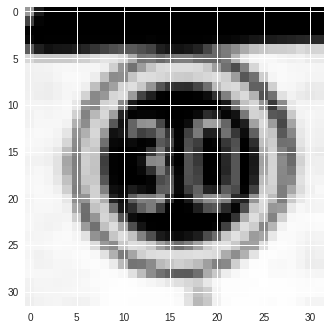

In [144]:
def grayscale(img):
  img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  return img

img = grayscale(X_train[3000])
plt.imshow(img)
#plt.axis("off")
print(img.shape)

Next We apply the Histogram Equalization technique to standardize lighting in all our images. Well because some images are more brighter and others very dim. Thus We need to give them a similar lighting effect. You can read about [Histogram Equalization Here](https://en.wikipedia.org/wiki/Histogram_equalization)

(32, 32)


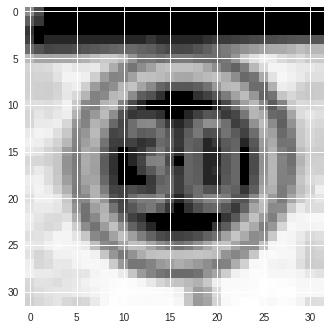

In [145]:
def equalize(img):
  img = cv2.equalizeHist(img)
  return img


img = equalize(img)
plt.imshow(img)
print(img.shape)

Next We apply Preprocessing to all our images.

In [0]:
def preprocessing(img):
  img = grayscale(img)
  img = equalize(img)
  #normalize the images, i.e. convert the pixel values to fit btwn 0 and 1
  img = img/255
  return img

Map Function Iterates through an entire array and perfoms a given operation. You can read about it  [here](https://www.journaldev.com/22960/python-map-function). So here we Preprocess all the images and update their variable storage.

In [0]:
X_train = np.array(list(map(preprocessing, X_train)))
X_val = np.array(list(map(preprocessing, X_val)))
X_test = np.array(list(map(preprocessing, X_test)))

We Plot a random image from our train data to see that its correctly preprocessed

(34799, 32, 32)


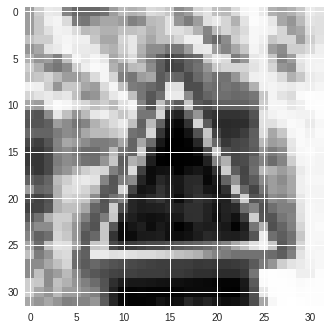

In [148]:
plt.imshow(X_train[random.randint(0, len(X_train) - 1)])
print(X_train.shape)

Next We add a depth to our images, that is required for our Convolutional Layer

In [0]:
X_train = X_train.reshape(34799, 32, 32, 1)
X_val = X_val.reshape(4410, 32, 32, 1)
X_test = X_test.reshape(12630, 32, 32, 1)


We generate variety datasets to better the model. Not *generate* but we show different angles and views of the same data set to the model for it to better identify the features.

In [0]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(width_shift_range=0.1,
                             height_shift_range=0.1,
                            zoom_range=0.2,
                            shear_range=0.1,
                            rotation_range=10.)

datagen.fit(X_train)

(15, 32, 32, 1)


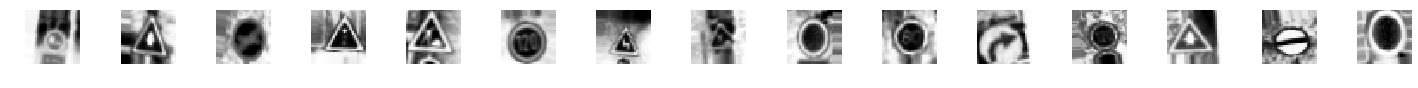

In [151]:
batches = datagen.flow(X_train, y_train, batch_size = 15)
X_batch, y_batch = next(batches)

fig, axs = plt.subplots(1, 15, figsize=(20, 5))
fig.tight_layout()

for i in range(15):
    axs[i].imshow(X_batch[i].reshape(32, 32))
    axs[i].axis("off")

print(X_batch.shape)

In [152]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(34799, 32, 32, 1)
(4410, 32, 32, 1)
(12630, 32, 32, 1)


Next One Hot Encode the data labels. Here's an article that explains what is [one-hot encoding](https://hackernoon.com/what-is-one-hot-encoding-why-and-when-do-you-have-to-use-it-e3c6186d008f). Also refer to the Keras to_categorical documentation [here](https://keras.io/utils/)

In [0]:
y_train = to_categorical(y_train, 43)
y_val = to_categorical(y_val, 43)
y_test = to_categorical(y_test, 43)

Next, It's time to define a leNet model. You may want to read about the LeNet model [here](https://medium.com/@mgazar/lenet-5-in-9-lines-of-code-using-keras-ac99294c8086)

In [0]:
def better_model():
  model = Sequential()
  # add the convolutional layer
  #filters, size of filters,input_shape,activation_function
  model.add(Conv2D(60,(5,5), input_shape= (32,32,1), activation = 'relu'))
  model.add(Conv2D(60,(5,5), input_shape= (32,32,1), activation = 'relu'))
  #pooling layer
  model.add(MaxPooling2D(pool_size = (2,2)))
  # add another convolutional layer
  model.add(Conv2D(30, (3, 3) , activation = 'relu'))
  model.add(Conv2D(30, (3, 3) , activation = 'relu'))
  # pooling layer
  model.add(MaxPooling2D(pool_size = (2,2)))
  
  #model.add(Dropout(0.5))
  
  #Flatten the image to 1 dimensional array
  model.add(Flatten())
  #add a dense layer : amount of nodes, activation
  model.add(Dense(500, activation = 'relu'))
  # place a dropout layer
  #0.5 drop out rate is recommended, half input nodes will be dropped at each update
  model.add(Dropout(0.5))
  # defining the ouput layer of our network
  model.add(Dense(num_classes, activation = 'softmax'))
  
  
  #Compile Model
  # we use Adam optimizer with a learning rate 0f 0.01
  # A categorical_crossentropy'
  
  model.compile(Adam(lr = 0.001), loss = 'categorical_crossentropy', metrics = ['accuracy'])
  
  return model

In [155]:
model = better_model()
#print a summary of the model
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_17 (Conv2D)           (None, 28, 28, 60)        1560      
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 24, 24, 60)        90060     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 12, 12, 60)        0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 10, 10, 30)        16230     
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 8, 8, 30)          8130      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 4, 4, 30)          0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 480)               0         
__________

Now to training and evaluating the model

In [156]:
# define our training paramters
history = model.fit_generator(datagen.flow(X_train, y_train, batch_size=50),
                            steps_per_epoch=2000,
                            epochs=15,
                            validation_data=(X_val, y_val), shuffle = 1)

Epoch 1/15
2000/2000 [==============================] - 54s 27ms/step - loss: 0.9098 - acc: 0.7367 - val_loss: 0.0967 - val_acc: 0.9694
Epoch 2/15
2000/2000 [==============================] - 52s 26ms/step - loss: 0.2203 - acc: 0.9305 - val_loss: 0.0432 - val_acc: 0.9889
Epoch 3/15
2000/2000 [==============================] - 52s 26ms/step - loss: 0.1472 - acc: 0.9536 - val_loss: 0.0400 - val_acc: 0.9878
Epoch 4/15
2000/2000 [==============================] - 53s 27ms/step - loss: 0.1127 - acc: 0.9650 - val_loss: 0.0345 - val_acc: 0.9909
Epoch 5/15
2000/2000 [==============================] - 53s 26ms/step - loss: 0.1012 - acc: 0.9687 - val_loss: 0.0719 - val_acc: 0.9823
Epoch 6/15
2000/2000 [==============================] - 52s 26ms/step - loss: 0.0869 - acc: 0.9733 - val_loss: 0.0258 - val_acc: 0.9941
Epoch 7/15
2000/2000 [==============================] - 52s 26ms/step - loss: 0.0798 - acc: 0.9757 - val_loss: 0.0267 - val_acc: 0.9923
Epoch 8/15
2000/2000 [==========================

Plotting and Visualizing how the network perfomed

Text(0.5, 0, 'epoch')

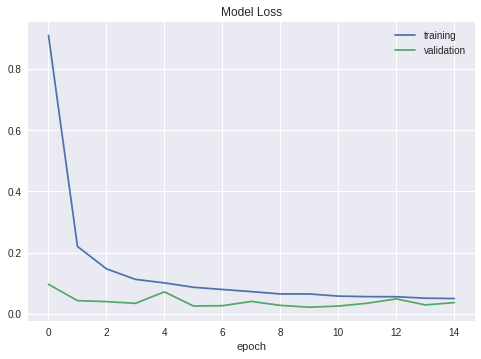

In [157]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title('Model Loss')
plt.xlabel('epoch')

Text(0.5, 0, 'epoch')

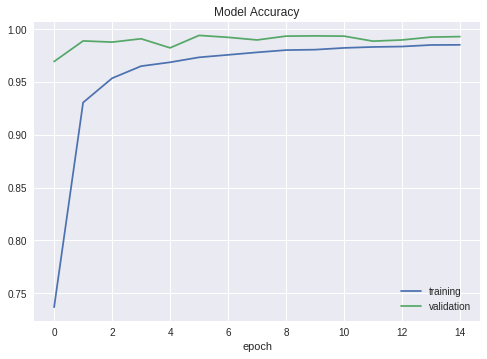

In [158]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.legend(['training', 'validation'])
plt.title('Model Accuracy')
plt.xlabel('epoch')

Evaluate the model

In [159]:
score = model.evaluate(X_test, y_test , verbose = 0)
print("The test score is: ",score[0])
print("The Accuracy score is: ",score[1])

The test score is:  0.13601741046945723
The Accuracy score is:  0.9753760886966285


Time to test the image on real images from the internet

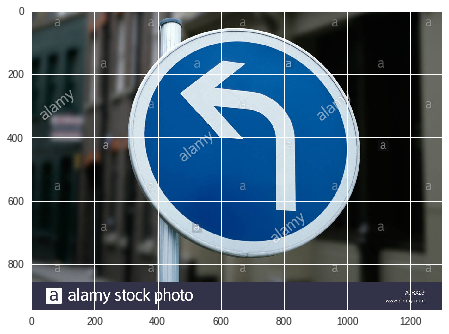

In [169]:
#fetch image

import requests
from PIL import Image
url = 'https://c8.alamy.com/comp/A0RX23/cars-and-automobiles-must-turn-left-ahead-sign-A0RX23.jpg'
r = requests.get(url, stream=True)
img = Image.open(r.raw)
plt.imshow(img, cmap=plt.get_cmap('gray'))


(32, 32)


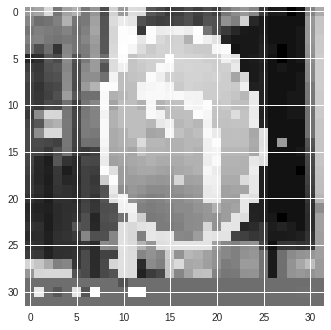

In [170]:
#Preprocess image

img = np.asarray(img)
img = cv2.resize(img, (32, 32))
img = preprocessing(img)
plt.imshow(img, cmap = plt.get_cmap('gray'))
print(img.shape)

In [0]:
#Reshape reshape

img = img.reshape(1, 32, 32, 1)

In [172]:
#Test image
print("The Predicted sign: "+ str(model.predict_classes(img)))

The Predicted sign: [34]


Saving the model for later use

In [0]:
from keras.models import load_model

model.save('my_model.h5')  # creates a HDF5 file 'my_model.h5'
del model # deletes the existing model

In [0]:
# returns a compiled model
# identical to the previous one
model = load_model('my_model.h5')

The saved Model can be tested now

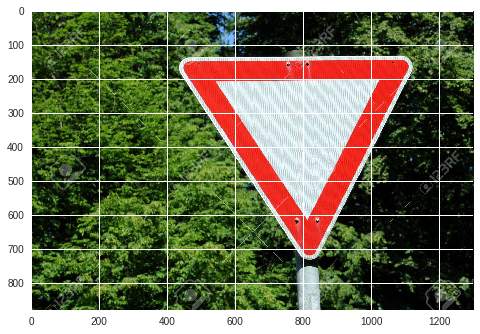

In [181]:
#Testing the Saved Model

#fetch image

import requests
from PIL import Image
url = 'https://previews.123rf.com/images/pejo/pejo0907/pejo090700003/5155701-german-traffic-sign-no-205-give-way.jpg'
r = requests.get(url, stream=True)
img = Image.open(r.raw)
plt.imshow(img, cmap=plt.get_cmap('gray'))

(32, 32)


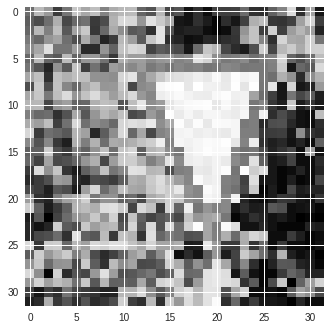

In [182]:
#Preprocess image

img = np.asarray(img)
img = cv2.resize(img, (32, 32))
img = preprocessing(img)
plt.imshow(img, cmap = plt.get_cmap('gray'))
print(img.shape)

In [0]:
#Reshape reshape

img = img.reshape(1, 32, 32, 1)

In [184]:
#Test image
print("The Predicted sign: "+ str(model.predict_classes(img)))

The Predicted sign: [13]
